# Train

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.datasets.datasets import LSTMDataset, get_dataset
from hython.trainer import train_val
from hython.sampler import SamplerBuilder, RegularIntervalDownsampler
from hython.metrics import MSEMetric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.trainer import RNNTrainer, RNNTrainParams
from hython.normalizer import Normalizer


import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR 1: PROJ: proj_create_from_database: Open of /home/iferrario/.local/miniforge/envs/emulator/share/proj failed


# Settings

In [3]:
# PARAMETERS 

EXPERIMENT  = "test"

SURROGATE_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_preprocessed.zarr/"

SURROGATE_MODEL_OUTPUT = f"/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/{EXPERIMENT}.pt"
TMP_STATS = "/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_stats"

# === FILTER ==============================================================

# train/test temporal range
train_temporal_range = slice("2016-01-01","2018-12-31")
test_temporal_range = slice("2019-01-01", "2020-12-31")

# variables
dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc", "actevap"]

# === MASK ========================================================================================

mask_names = ["mask_missing", "mask_lake"] # names depends on preprocessing application

# === DATASET ========================================================================================

DATASET = "LSTMDataset" # "XBatchDataset"

# == MODEL  ========================================================================================

HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:1/len(target_names) for t in target_names}


# === SAMPLER/TRAINER ===================================================================================

# downsampling
DONWSAMPLING = True


SEED = 1696
EPOCHS = 40
BATCH = 256

TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = [150, 150] 
SEQ_LENGTH = 60


assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"



In [4]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# === READ TRAIN ===================================================================
Xd = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=SURROGATE_INPUT , group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]

# === READ TEST ===================================================================

Y_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="y", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .y.sel(feat=target_names)
)
Xd_test = (
    read_from_zarr(url=SURROGATE_INPUT , group="xd", multi_index="gridcell")
    .sel(time=test_temporal_range)
    .xd.sel(feat=dynamic_names)
)

In [6]:
masks = (
    read_from_zarr(url=SURROGATE_INPUT, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

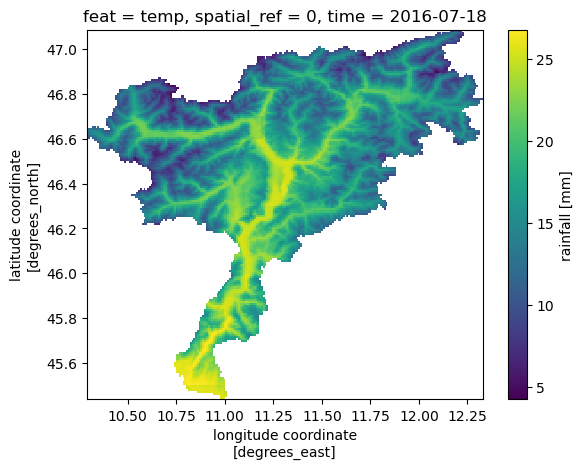

In [19]:
# viz input
Xd.unstack().isel(time=199).sel(feat="temp").plot()

In [8]:
if DONWSAMPLING:
   train_downsampler = RegularIntervalDownsampler(
        intervals=[3,3], origin=[0,0]
    )       
   test_downsampler = RegularIntervalDownsampler(
        intervals=[3,3], origin=[2,2]
    )
else:
    train_downsampler,test_downsampler = None,None

In [10]:
# === NORMALIZE ======================================================================

normalizer_dynamic = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xd.npy")
normalizer_static = Normalizer(method="standardize", type="space", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_xs.npy")
normalizer_target = Normalizer(method="standardize", type="spacetime", axis_order = "NTC", save_stats= f"{TMP_STATS}/{EXPERIMENT}_y.npy")


In [ ]:
# === DATSET =======================================================================

train_dataset = get_dataset(DATASET)(
        Xd,
        Y,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = train_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)
test_dataset = get_dataset(DATASET)(
        Xd_test,
        Y_test,
        Xs,
        original_domain_shape=SHAPE,
        mask = masks,
        downsampler = test_downsampler,
        normalizer_dynamic = normalizer_dynamic,
        normalizer_static = normalizer_static,
        normalizer_target = normalizer_target
)

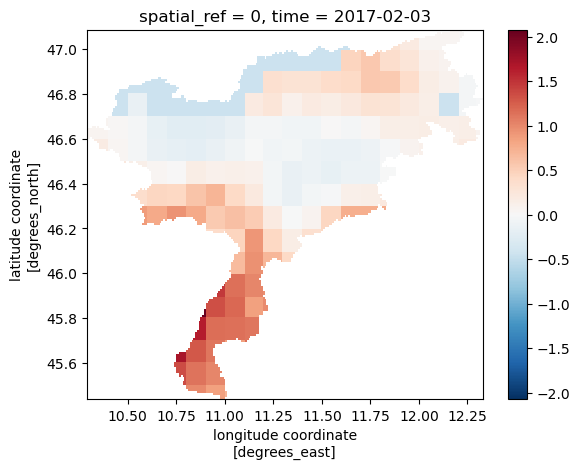

In [20]:
# viz torch datasets
from hython.utils import reshape_to_2Dspatial, to_xr
coords = read_from_zarr("https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_original.zarr/", group="xd").sel(time=train_temporal_range).coords
to_xr(reshape_to_2Dspatial(np.array(train_dataset.xd), *SHAPE, Xd.shape[1], Xd.shape[-1])[...,0], coords=coords).isel(time=399).plot()

In [12]:
# === SAMPLER ===================================================================

train_sampler_builder = SamplerBuilder(
                                        minibatch_sampling="random", 
                                        processing="single-gpu")

test_sampler_builder = SamplerBuilder(
                                        minibatch_sampling="sequential", 
                                        processing="single-gpu")

train_sampler_builder.initialize(
    train_dataset
)
test_sampler_builder.initialize(
    test_dataset
)

train_sampler = train_sampler_builder.get_sampler()
test_sampler = test_sampler_builder.get_sampler()

In [14]:
# === DATA LOADER ================================================================

train_loader = DataLoader(train_dataset, batch_size=BATCH , sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH , sampler=test_sampler)

In [15]:
# === MODEL ===================================================================

model = CuDNNLSTM(
                hidden_size=HIDDEN_SIZE, 
                dynamic_input_size=DYNAMIC_INPUT_SIZE,
                static_input_size=STATIC_INPUT_SIZE, 
                output_size=OUTPUT_SIZE
)

model.to(device)


CuDNNLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

In [16]:
# === TRAIN ===================================================================
    
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)
metric_fn = MSEMetric(target_names=target_names)

trainer = RNNTrainer(
    RNNTrainParams(
            experiment=EXPERIMENT,
            temporal_subsampling=TEMPORAL_SUBSAMPLING, 
            temporal_subset=TEMPORAL_SUBSET, 
            seq_length=SEQ_LENGTH, 
            target_names=target_names,
            metric_func=metric_fn,
            loss_func=loss_fn)
)

In [17]:
model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    test_loader,
    EPOCHS,
    opt,
    lr_scheduler,
    SURROGATE_MODEL_OUTPUT,
    device
)


  5%|████▊                                                                                            | 1/20 [00:04<01:28,  4.67s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.24631452560424805
val loss: 0.20121055841445923


 10%|█████████▋                                                                                       | 2/20 [00:08<01:11,  3.97s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.16457676887512207
val loss: 0.18958906829357147


 15%|██████████████▌                                                                                  | 3/20 [00:11<01:04,  3.79s/it]

train loss: 0.15067434310913086
val loss: 0.1995052993297577


 20%|███████████████████▍                                                                             | 4/20 [00:15<00:58,  3.67s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.14496970176696777
val loss: 0.1741241216659546


 25%|████████████████████████▎                                                                        | 5/20 [00:18<00:53,  3.60s/it]

train loss: 0.1343322992324829
val loss: 0.1769520491361618


 30%|█████████████████████████████                                                                    | 6/20 [00:22<00:50,  3.57s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.13144631683826447
val loss: 0.16423963010311127


 35%|█████████████████████████████████▉                                                               | 7/20 [00:25<00:46,  3.56s/it]

train loss: 0.1242852509021759
val loss: 0.16949519515037537


 40%|██████████████████████████████████████▊                                                          | 8/20 [00:29<00:42,  3.55s/it]

train loss: 0.11949710547924042
val loss: 0.17333310842514038


 45%|███████████████████████████████████████████▋                                                     | 9/20 [00:32<00:39,  3.55s/it]

train loss: 0.12497508525848389
val loss: 0.16587483882904053


 50%|████████████████████████████████████████████████                                                | 10/20 [00:36<00:35,  3.55s/it]

train loss: 0.1205250471830368
val loss: 0.16443002223968506


 55%|████████████████████████████████████████████████████▊                                           | 11/20 [00:39<00:31,  3.55s/it]

train loss: 0.11939805746078491
val loss: 0.16562552750110626


 60%|█████████████████████████████████████████████████████████▌                                      | 12/20 [00:43<00:28,  3.56s/it]

train loss: 0.11703818291425705
val loss: 0.16444385051727295


 65%|██████████████████████████████████████████████████████████████▍                                 | 13/20 [00:47<00:24,  3.56s/it]

train loss: 0.11422502249479294
val loss: 0.16586370766162872


 70%|███████████████████████████████████████████████████████████████████▏                            | 14/20 [00:50<00:21,  3.55s/it]

train loss: 0.1157621443271637
val loss: 0.16555655002593994


 75%|████████████████████████████████████████████████████████████████████████                        | 15/20 [00:54<00:17,  3.57s/it]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model/test.pt
Copied best model weights!
train loss: 0.11285212635993958
val loss: 0.1547441929578781


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 16/20 [00:57<00:14,  3.56s/it]

train loss: 0.10590348392724991
val loss: 0.15928339958190918


 85%|█████████████████████████████████████████████████████████████████████████████████▌              | 17/20 [01:01<00:10,  3.56s/it]

train loss: 0.12005534768104553
val loss: 0.1681327521800995


 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 18/20 [01:04<00:07,  3.58s/it]

train loss: 0.11236549913883209
val loss: 0.16086560487747192


 95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 19/20 [01:08<00:03,  3.59s/it]

train loss: 0.11161713302135468
val loss: 0.16212670505046844


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it]

train loss: 0.11382456868886948
val loss: 0.15765267610549927


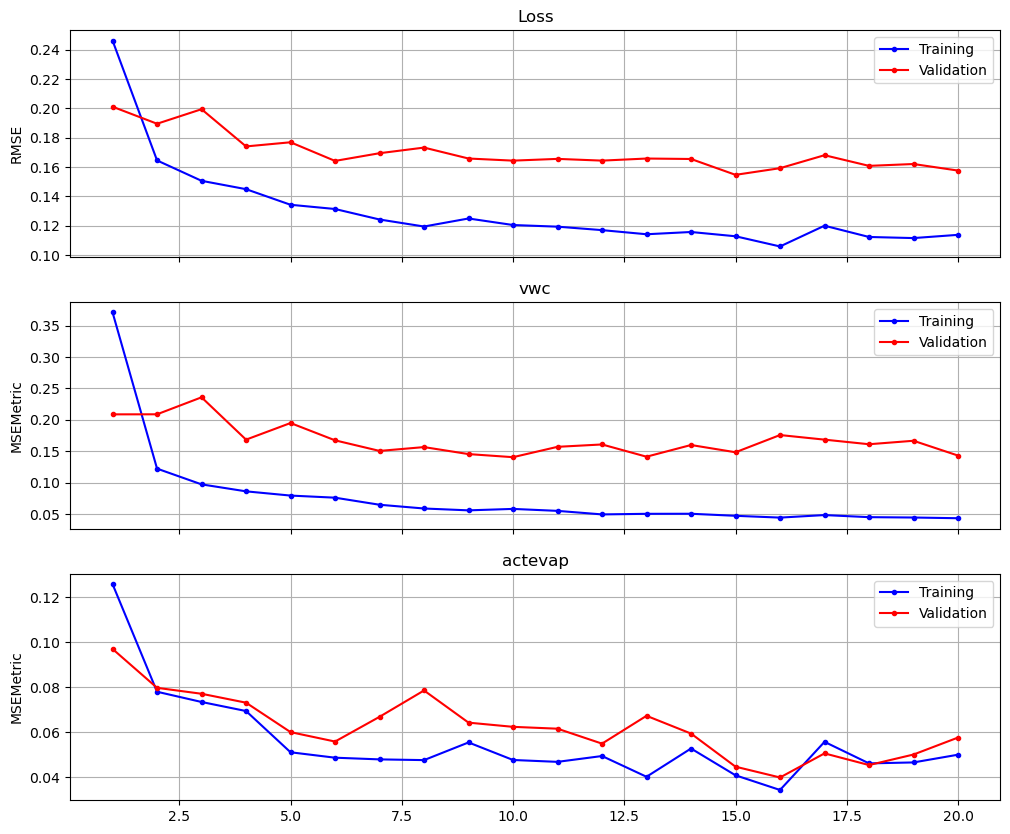

In [21]:
lepochs = list(range(1, EPOCHS + 1))

fig, axs = plt.subplots(len(target_names) +1, 1, figsize= (12,10), sharex=True)

axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, [i.detach().cpu().numpy() for i in loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
axs[0].set_title('Loss')
axs[0].set_ylabel(loss_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

for i, variable in enumerate(target_names):
    axs[i+1].plot(lepochs, metric_history[f'train_{variable}'], marker='.', linestyle='-', color='b', label='Training')
    axs[i+1].plot(lepochs, metric_history[f'val_{variable}'], marker='.', linestyle='-', color='r', label='Validation')
    axs[i+1].set_title(variable)
    axs[i+1].set_ylabel(metric_fn.__class__.__name__)
    axs[i+1].grid(True)
    axs[i+1].legend(bbox_to_anchor=(1,1))